In [3]:
import numpy as np
import pandas as pd
import re
import nltk 
from nltk.corpus import stopwords
import pickle
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import textdescriptives as td
import spacy
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/danielcrovo/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/danielcrovo/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/danielcrovo/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/danielcrovo/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/danielcrovo/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    |

True

In [2]:
file_path = "./age_tweets_v2 - age_tweets_v2.csv.csv"
df = pd.read_csv(file_path, sep=',')
df


text age_range
0       RT @forotw: Respetemos la Semana Santa. @Raulk...     35-49
1       RT @bluepoltergeist: No importa que usted sea ...     35-49
2       RT @LuxuryColumnist: What do you think of this...     35-49
3       Un milagro! Dios rtsp://v2.cache6.c.youtube.co...     35-49
4       RT @Bogota: En #LaCiudadDeLosSuenos 200 jovene...     35-49
...                                                   ...       ...
300016  @CAmanecioCali uffff ! Si lagente se diera cue...     35-49
300017  Presentaran ante tribunales a camarografo dete...     35-49
300018  Me ha gustado un video de @YouTube (http://t.c...     35-49
300019  RT @24HorasTVN: Los memes" que identifican a l...     35-49
300020  RT @ClaudiaLopez: Denuncie con pruebas corrupc...     35-49

[300021 rows x 2 columns]

In [3]:
#Se revisan valores nulos
df['age_range'].isna().value_counts() 

age_range
False    299993
True         28
Name: count, dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.isna().value_counts()

text   age_range
False  False        299833
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['age_range'].unique())

LabelEncoder()

In [7]:
le.classes_

array(['13-17', '18-24', '25-34', '35-49', '50-64', '65-xx'], dtype=object)

In [8]:
df_tweets = df.copy()

In [9]:
df_tweets['classes'] = le.transform(df['age_range'])

## Preprocesamiento de Tweets

In [10]:
import re 

stop_words = set(stopwords.words('spanish'))
def remove_retweet(text):
    return re.sub('RT @[\w_]+:', '', text)

def remove_video(text):
    return re.sub('VIDEO:', '', text)

def remove_hyperlink(text):
    return re.sub(r'http\S+', '', text)

def remove_user(text):
    return re.sub('@[A-Za-z0-9_]+(:)?', '', text)

def remove_line_break(text):
    return re.sub(r'\n', '', text)

def remove_extra_spaces(text):
    return re.sub(r"\s+", " ", text)

def data_clenaning(text): 
    text = remove_retweet(text)
    text = remove_video(text)
    text = remove_hyperlink(text)
    text = remove_user(text)
    text = remove_line_break(text)
    text = remove_extra_spaces(text)
    text = re.sub(r'rtsp://[^\s]+', '',text)
    return text



In [11]:
df_tweets['processed_text'] = df_tweets['text'].apply(data_clenaning)
docs_un = df_tweets['text'].tolist()
docs_proc = df_tweets['processed_text'].tolist()

In [35]:
import spacy
# metrics = td.extract_metrics(
#     text=df_tweets['text'], 
#     spacy_model="es_core_news_lg",
#     metrics=["readability", "dependency_distance"],
# )

nlp = spacy.load("es_core_news_lg")
nlp.add_pipe("textdescriptives/descriptive_stats")

docs = nlp.pipe(docs_proc)
df_test = td.extract_df(docs)


In [38]:
df_features = df_test.drop(['text'], axis=1).join(df_tweets)

In [39]:
df_features

dependency_distance_mean  dependency_distance_std   
0                       0.800000                 0.800000  \
1                       1.860000                 1.860000   
2                       2.676471                 2.676471   
3                       0.333333                 0.333333   
4                       1.854167                 1.854167   
...                          ...                      ...   
299828                  0.900000                 0.941630   
299829                  2.666667                 0.000000   
299830                  2.823529                 0.000000   
299831                  1.218750                 1.218750   
299832                  1.659091                 1.659091   

        prop_adjacent_dependency_relation_mean   
0                                     0.200000  \
1                                     0.160000   
2                                     0.147059   
3                                     0.333333   
4                                     0.208333   
...                                        ...   
299828                                0.300000   
299829                                0.466667   
299830                                0.411765   
299831                                0.187500   
299832                                0.227273   

        prop_adjacent_dependency_relation_std  flesch_reading_ease   
0                                    0.200000            18.177500  \
1                                    0.160000            46.605000   
2                                    0.147059            58.222500   
3                                    0.333333            64.312500   
4                                    0.208333            25.962500   
...                                       ...                  ...   
299828                               0.216025            61.742157   
299829                               0.000000            -6.789286   
299830                               0.000000            41.851818   
299831                               0.187500            69.502500   
299832                               0.227273            35.034643   

        flesch_kincaid_grade      smog  gunning_fog   
0                  11.345000       NaN    17.000000  \
1                   9.740000       NaN    13.133333   
2                   7.001667       NaN     8.333333   
3                   4.661667       NaN    13.933333   
4                  12.495000       NaN    15.034783   
...                      ...       ...          ...   
299828              6.055294  8.841846     9.325490   
299829             17.684286       NaN    19.885714   
299830             10.154545       NaN    15.309091   
299831              5.428333       NaN     8.333333   
299832             10.981190       NaN    15.628571   

        automated_readability_index  coleman_liau_index  ...   
0                          2.428000            0.584000  ...  \
1                          3.213750            5.008333  ...   
2                          3.358000            6.517333  ...   
3                         -0.270000          -10.053333  ...   
4                          5.207826            7.702609  ...   
...                             ...                 ...  ...   
299828                     1.628627            4.225882  ...   
299829                    11.475000           14.425714  ...   
299830                     5.050909            7.701818  ...   
299831                     0.846000            3.381333  ...   
299832                     6.472857            9.660952  ...   

        syllables_per_token_std  n_tokens  n_unique_tokens   
0                      1.166190         5                5  \
1                      1.010363        24               21   
2                      1.299573        15               15   
3                      0.942809         3                3   
4                      1.693979        23               20   
...                         ...

In [40]:
def tokenizer(text):
    tokenizer= TweetTokenizer()
    return tokenizer.tokenize(text)


df_tweets['tokens'] = df_tweets['processed_text'].apply(tokenizer)
    

In [41]:
df_tweets

text age_range  classes   
0       RT @forotw: Respetemos la Semana Santa. @Raulk...     35-49        3  \
1       RT @bluepoltergeist: No importa que usted sea ...     35-49        3   
2       RT @LuxuryColumnist: What do you think of this...     35-49        3   
3       Un milagro! Dios rtsp://v2.cache6.c.youtube.co...     35-49        3   
4       RT @Bogota: En #LaCiudadDeLosSuenos 200 jovene...     35-49        3   
...                                                   ...       ...      ...   
300016  @CAmanecioCali uffff ! Si lagente se diera cue...     35-49        3   
300017  Presentaran ante tribunales a camarografo dete...     35-49        3   
300018  Me ha gustado un video de @YouTube (http://t.c...     35-49        3   
300019  RT @24HorasTVN: Los memes" que identifican a l...     35-49        3   
300020  RT @ClaudiaLopez: Denuncie con pruebas corrupc...     35-49        3   

                                           processed_text   
0                            Respetemos la Semana Santa.   \
1        No importa que usted sea uribista, si no ve q...   
2        What do you think of this street art by local...   
3                                       Un milagro! Dios    
4        En #LaCiudadDeLosSuenos 200 jovenes ya disfru...   
...                                                   ...   
300016   uffff ! Si lagente se diera cuenta de que el ...   
300017  Presentaran ante tribunales a camarografo dete...   
300018  Me ha gustado un video de ( - Testimonio de Al...   
300019   Los memes" que identifican a los solteros a p...   
300020   Denuncie con pruebas corrupcion desde Preside...   

                                                   tokens  
0                      [Respetemos, la, Semana, Santa, .]  
1       [No, importa, que, usted, sea, uribista, ,, si...  
2       [What, do, you, think, of, this, street, art, ...  
3                                  [Un, milagro, !, Dios]  
4       [En, #LaCiudadDeLosSuenos, 200, jovenes, ya, d...  
...                                                   ...  
300016  [uffff, !, Si, lagente, se, diera, cuenta, de,...  
300017  [Presentaran, ante, tribunales, a, camarografo...  
300018  [Me, ha, gustado, un, video, de, (, -, Testimo...  
300019  [Los, memes, ", que, identifican, a, los, solt...  
300020  [Denuncie, con, pruebas, corrupcion, desde, Pr...  

[299833 rows x 5 columns]

## Extracción de caraterísticas

In [43]:
import emoji

def count_mentions(text):
    return len(re.findall(r'@[\w_]+', text))

def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

def count_urls(text):
    return len(re.findall(r'http\S+', text))

def count_videos(text):
    return len(re.findall(r'rtsp://[^\s]+', text))

def count_emoticons(tokens):
    # Define a pattern to match common emoticons
    emoticon_pattern = r'(:-?\)|:-?D|;-?\)|:-?\(|:-?\[|:-?P|:\'\(|>:\(|:\||:O|:-\||:D|B\)|:o\)|:-\*|xD|X-?D|<3)'

    # Join the tokens into a string
    text = ' '.join(tokens)

    # Count the number of emoticons
    return len(re.findall(emoticon_pattern, text))

def count_uppercase(text):
    # Count the number of uppercase letters (excluding URLs)
    text_without_urls = re.sub(r'http\S+', '', text)  # Remove URLs
    return sum(1 for char in text_without_urls if char.isupper())




df_tweets['n_mentions'] = df_tweets['text'].apply(count_mentions)
df_tweets['n_hashtags'] = df_tweets['text'].apply(count_hashtags)
df_tweets['n_urls'] = df_tweets['text'].apply(count_urls)
df_tweets['n_emoticons'] = df_tweets['tokens'].apply(count_emoticons)
df_tweets['n_uppercase'] = df_tweets['text'].apply(count_uppercase)

In [44]:
df_tweets



text age_range  classes   
0       RT @forotw: Respetemos la Semana Santa. @Raulk...     35-49        3  \
1       RT @bluepoltergeist: No importa que usted sea ...     35-49        3   
2       RT @LuxuryColumnist: What do you think of this...     35-49        3   
3       Un milagro! Dios rtsp://v2.cache6.c.youtube.co...     35-49        3   
4       RT @Bogota: En #LaCiudadDeLosSuenos 200 jovene...     35-49        3   
...                                                   ...       ...      ...   
300016  @CAmanecioCali uffff ! Si lagente se diera cue...     35-49        3   
300017  Presentaran ante tribunales a camarografo dete...     35-49        3   
300018  Me ha gustado un video de @YouTube (http://t.c...     35-49        3   
300019  RT @24HorasTVN: Los memes" que identifican a l...     35-49        3   
300020  RT @ClaudiaLopez: Denuncie con pruebas corrupc...     35-49        3   

                                           processed_text   
0                            Respetemos la Semana Santa.   \
1        No importa que usted sea uribista, si no ve q...   
2        What do you think of this street art by local...   
3                                       Un milagro! Dios    
4        En #LaCiudadDeLosSuenos 200 jovenes ya disfru...   
...                                                   ...   
300016   uffff ! Si lagente se diera cuenta de que el ...   
300017  Presentaran ante tribunales a camarografo dete...   
300018  Me ha gustado un video de ( - Testimonio de Al...   
300019   Los memes" que identifican a los solteros a p...   
300020   Denuncie con pruebas corrupcion desde Preside...   

                                                   tokens  n_mentions   
0                      [Respetemos, la, Semana, Santa, .]           5  \
1       [No, importa, que, usted, sea, uribista, ,, si...           1   
2       [What, do, you, think, of, this, street, art, ...           2   
3                                  [Un, milagro, !, Dios]           0   
4       [En, #LaCiudadDeLosSuenos, 200, jovenes, ya, d...           1   
...                                                   ...         ...   
300016  [uffff, !, Si, lagente, se, diera, cuenta, de,...           1   
300017  [Presentaran, ante, tribunales, a, camarografo...           0   
300018  [Me, ha, gustado, un, video, de, (, -, Testimo...           1   
300019  [Los, memes, ", que, identifican, a, los, solt...           1   
300020  [Denuncie, con, pruebas, corrupcion, desde, Pr...           1   

        n_hashtags  n_urls  n_emoticons  n_uppercase  
0                0       1            0            6  
1                0       0            0            4  
2                3       1            0            7  
3                0       0            0           44  
4                1       0            0           12  
...            ...     ...          ...          ...  
300016           0       0            0            4  
300017           1       2            0            4  
300018           0       1            0            7  
300019           0       2            0            7  
300020           0       0            0            8  

[299833 rows x 10 columns]

In [45]:
df_features = df_test.drop(['text'], axis=1).join(df_tweets)
df_features

dependency_distance_mean  dependency_distance_std   
0                       0.800000                 0.800000  \
1                       1.860000                 1.860000   
2                       2.676471                 2.676471   
3                       0.333333                 0.333333   
4                       1.854167                 1.854167   
...                          ...                      ...   
299828                  0.900000                 0.941630   
299829                  2.666667                 0.000000   
299830                  2.823529                 0.000000   
299831                  1.218750                 1.218750   
299832                  1.659091                 1.659091   

        prop_adjacent_dependency_relation_mean   
0                                     0.200000  \
1                                     0.160000   
2                                     0.147059   
3                                     0.333333   
4                                     0.208333   
...                                        ...   
299828                                0.300000   
299829                                0.466667   
299830                                0.411765   
299831                                0.187500   
299832                                0.227273   

        prop_adjacent_dependency_relation_std  flesch_reading_ease   
0                                    0.200000            18.177500  \
1                                    0.160000            46.605000   
2                                    0.147059            58.222500   
3                                    0.333333            64.312500   
4                                    0.208333            25.962500   
...                                       ...                  ...   
299828                               0.216025            61.742157   
299829                               0.000000            -6.789286   
299830                               0.000000            41.851818   
299831                               0.187500            69.502500   
299832                               0.227273            35.034643   

        flesch_kincaid_grade      smog  gunning_fog   
0                  11.345000       NaN    17.000000  \
1                   9.740000       NaN    13.133333   
2                   7.001667       NaN     8.333333   
3                   4.661667       NaN    13.933333   
4                  12.495000       NaN    15.034783   
...                      ...       ...          ...   
299828              6.055294  8.841846     9.325490   
299829             17.684286       NaN    19.885714   
299830             10.154545       NaN    15.309091   
299831              5.428333       NaN     8.333333   
299832             10.981190       NaN    15.628571   

        automated_readability_index  coleman_liau_index  ...   
0                          2.428000            0.584000  ...  \
1                          3.213750            5.008333  ...   
2                          3.358000            6.517333  ...   
3                         -0.270000          -10.053333  ...   
4                          5.207826            7.702609  ...   
...                             ...                 ...  ...   
299828                     1.628627            4.225882  ...   
299829                    11.475000           14.425714  ...   
299830                     5.050909            7.701818  ...   
299831                     0.846000            3.381333  ...   
299832                     6.472857            9.660952  ...   

                                                     text  age_range  classes   
0       RT @forotw: Respetemos la Semana Santa. @Raulk...      35-49      3.0  \
1       RT @bluepoltergeist: No importa que usted sea ...      35-49      3.0   
2       RT @LuxuryColumnist: What do you think of this...      35-49      3.0   
3       Un milagro! Dios rtsp://v2.cache6.c.youtube.co...      35-49      3.0  

In [56]:
from sklearn.model_selection import train_test_split
features = df_features.drop(['text', 'age_range', 'processed_text', 'tokens', 'smog'], axis=1).dropna()
features.to_csv('./features.csv')
X = features.values
y = features['classes'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Probando un classificador sencillo (baseline)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score


pipe = Pipeline([('scaler', StandardScaler())])


In [126]:
modelB = LogisticRegression ()

X_train_s = X_train
X_test_s = X_test
modelB.fit(X_train_s, y_train)
train_preds = modelB.predict(X_train_s)
preds = modelB.predict(X_test_s)
train_f1 = f1_score(y_train, train_preds, average='micro')
test_f1 = f1_score(y_test, preds, average='micro')
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, preds)
train_roc = roc_auc_score(y_train, modelB.predict_proba(X_train_s), multi_class='ovr')
test_roc = roc_auc_score(y_test, modelB.predict_proba(X_test_s), multi_class='ovr')

print(f'Model: Logistic Regression')
print(f'Training F1: {train_f1}')
print(f'Test F1: {test_f1}')
print(f'Training ROC AUC: {train_roc}')
print(f'Test ROC AUC: {test_roc}')
print(f'Training Acc: {train_acc}')
print(f'Test Acc: {test_acc}')
print('-----------------------')   

/home/danielcrovo/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Training F1: 0.9225541986991358
Test F1: 0.9206983709873175
Training ROC AUC: 0.9894945608653657
Test ROC AUC: 0.9891175685638739
Training Acc: 0.9225541986991358
Test Acc: 0.9206983709873175
-----------------------


In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import timeit
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier




In [128]:
def get_models():
    models = dict()
    
    models['Logistic Regression'] = LogisticRegression(random_state=42, max_iter=1000)
    
    models['Decision Tree'] = DecisionTreeClassifier(random_state=42)
    
    models['Random Forest'] = RandomForestClassifier(random_state=42)
    
    models['Extra Trees'] = ExtraTreesClassifier(random_state=42)
    
    models['Gradient Boosting'] = GradientBoostingClassifier(random_state=42)
    
    models['Hist Gradient Boosting'] = HistGradientBoostingClassifier(random_state=42)
    
    models['AdaBoost'] = AdaBoostClassifier(random_state=42) 
                
    
    return models

In [129]:
models = get_models()
results = list()
def evaluate_models(X_train, X_test, y_train, y_test, pipe):
    for name, model in models.items():
        X_train_s = pipe.fit_transform(X_train)
        X_test_s = pipe.fit_transform(X_test)
        model.fit(X_train_s, y_train)
        train_preds = model.predict(X_train_s)
        preds = model.predict(X_test_s)
        train_f1 = f1_score(y_train, train_preds, average='micro')
        test_f1 = f1_score(y_test, preds, average='micro')
        train_acc = accuracy_score(y_train, train_preds)
        test_acc = accuracy_score(y_test, preds)
        train_roc = roc_auc_score(y_train, model.predict_proba(X_train_s), multi_class='ovr')
        test_roc = roc_auc_score(y_test, model.predict_proba(X_test_s), multi_class='ovr')
        scores = {'name': name, 
                  'train_f1': train_f1, 
                  'test_f1': test_f1, 
                  'train_roc': train_roc, 
                  'test_roc': test_roc,
                  'train_acc': train_acc, 
                  'test_acc': test_acc}
        
        
        print(f'Model: {name}')
        print(f'Training F1: {train_f1}')
        print(f'Test F1: {test_f1}')
        print(f'Training ROC AUC: {train_roc}')
        print(f'Test ROC AUC: {test_roc}')
        print(f'Training Acc: {train_acc}')
        print(f'Test Acc: {test_acc}')
        print('-----------------------')        
        results.append(scores)



In [130]:
evaluate_models(X_train, X_test, y_train, y_test, pipe)

Model: Logistic Regression
Training F1: 1.0
Test F1: 1.0
Training ROC AUC: 1.0
Test ROC AUC: 1.0
Training Acc: 1.0
Test Acc: 1.0
-----------------------
Model: Decision Tree
Training F1: 1.0
Test F1: 1.0
Training ROC AUC: 1.0
Test ROC AUC: 1.0
Training Acc: 1.0
Test Acc: 1.0
-----------------------
Model: Random Forest
Training F1: 1.0
Test F1: 0.9997995746528744
Training ROC AUC: 1.0
Test ROC AUC: 0.999999727815973
Training Acc: 1.0
Test Acc: 0.9997995746528744
-----------------------
Model: Extra Trees
Training F1: 1.0
Test F1: 1.0
Training ROC AUC: 1.0
Test ROC AUC: 1.0
Training Acc: 1.0
Test Acc: 1.0
-----------------------


# Punto 2


In [4]:
def read_and_convert(filename):
    id_list = []
    topic_list = []
    text_list = []

    # Variables temporales para almacenar los datos hasta que se confirme que están en el orden correcto
    temp_id = None
    temp_topic = None
    temp_text = None

    # Estado inicial
    expected = "id"

    with open(filename, 'r') as file:
        for line in file:
            if "_id" in line and expected == "id":
                temp_id = line.replace('"_id" : "', '').replace(',', '').strip()
                expected = "topic"
            elif "topic" in line and expected == "topic":
                temp_topic = line.replace('"topic" : "', '').replace('",', '').strip()
                expected = "text"
            elif "text" in line and expected == "text":
                temp_text = line.replace('"text" : "', '').replace('",', '').strip()
                # Confirmamos que todos los campos están y los añadimos a las listas
                id_list.append(temp_id)
                topic_list.append(temp_topic)
                text_list.append(temp_text)
                # Reiniciamos el estado y las variables temporales
                expected = "id"
                temp_id = None
                temp_topic = None
                temp_text = None
            else:
                # Si no se cumple el orden, reiniciamos el estado y las variables temporales
                expected = "id"
                temp_id = None
                temp_topic = None
                temp_text = None

    return id_list, text_list, topic_list

In [5]:
filename = "./Corpus_News_LatinoAmerica/news_2020_colombia.json"
id, text, topic = read_and_convert(filename)

# Crear el dataframe
df_colombia = pd.DataFrame({
    "id": id,
    "text": text,
    "topic": topic
})

# Reemplazar los patrones por vacío
patterns_to_replace = ['"_id" : ', '"text" : "', '"topic" : "', '",']
for pattern in patterns_to_replace:
    df_colombia = df_colombia.replace(pattern, '', regex=True)

In [6]:
df_colombia

id   
0      ObjectId("5fc67d400c0ad7d76d154f56")  \
1      ObjectId("5fc67d420c0ad7d76d154f58")   
2      ObjectId("5fc67d450c0ad7d76d154f5a")   
3      ObjectId("5fc67d470c0ad7d76d154f5c")   
4      ObjectId("5fc67d490c0ad7d76d154f5e")   
...                                     ...   
17530  ObjectId("5fee23640867e98d18cf8d96")   
17531  ObjectId("5fee23670867e98d18cf8d9a")   
17532  ObjectId("5fee236d0867e98d18cf8da4")   
17533  ObjectId("5fee236f0867e98d18cf8da8")   
17534  ObjectId("5fee23720867e98d18cf8dac")   

                                                    text     topic  
0      La Registraduría Nacional fijó en 52.000 pesos...  politica  
1      Presentar proyectos de ley para ‘tocar’ el sue...  politica  
2      La emergencia sanitaria, que está activa desde...  politica  
3      La reforma al código electoral, que trae modif...  politica  
4      Campesinos, comerciantes, niños, miembros de l...  politica  
...                                                  ...       ...  
17530  Los gatos tienen fama de ser animales de carác...      vida  
17531  Si un perro tiene diabetes, es muy probable qu...      vida  
17532  Un experimento científico, transmitido en vivo...      vida  
17533  En Colombia, durante el confinamiento las búsq...      vida  
17534  La semana pasada se dieron a conocer las ciuda...      vida  

[17535 rows x 3 columns]

In [7]:
filename = "./Corpus_News_LatinoAmerica/news_2020_ecuador.json"
id, text, topic = read_and_convert(filename)

# Crear el dataframe
df_ecuador = pd.DataFrame({
    "id": id,
    "text": text,
    "topic": topic
})

# Reemplazar los patrones por vacío
patterns_to_replace = ['"_id" : ', '"text" : "', '"topic" : "', '",']
for pattern in patterns_to_replace:
    df_ecuador = df_ecuador.replace(pattern, '', regex=True)

In [8]:
df_ecuador

id   
0      ObjectId("5fc692a50c0ad7d76d155aa6")  \
1      ObjectId("5fc692ab0c0ad7d76d155aa8")   
2      ObjectId("5fc692b20c0ad7d76d155aaa")   
3      ObjectId("5fc692ba0c0ad7d76d155aac")   
4      ObjectId("5fc692c10c0ad7d76d155aae")   
...                                     ...   
20027  ObjectId("5fee294b0867e98d18cf9358")   
20028  ObjectId("5fee294e0867e98d18cf935a")   
20029  ObjectId("5fee29510867e98d18cf935c")   
20030  ObjectId("5fee29540867e98d18cf935e")   
20031  ObjectId("5fee29570867e98d18cf9360")   

                                                    text        topic  
0      El XVII Gabinete Sectorial de Seguridad resolv...     politica  
1      Esta mañana, desde el Palacio de Carondelet, e...     politica  
2      Las actividades legislativas y de las comision...     politica  
3      El 7 de febrero del 2021 los ecuatorianos volv...     politica  
4      La madrugada de este martes, un Tribunal de Pi...     politica  
...                                                  ...          ...  
20027  Varias organizaciones y sindicatos de obreros ...  cuerpo-alma  
20028  El 9 de octubre de 1820 es una de las fechas m...  cuerpo-alma  
20029  Para evocar a personajes que laboraron y aport...  cuerpo-alma  
20030  Existen instituciones cuyas labores solidarias...  cuerpo-alma  
20031  A orillas del río Guayas se levanta el barrio ...  cuerpo-alma  

[20032 rows x 3 columns]

In [9]:
filename = "./Corpus_News_LatinoAmerica/news_2020_peru.json"
id, text, topic = read_and_convert(filename)

# Crear el dataframe
df_peru = pd.DataFrame({
    "id": id,
    "text": text,
    "topic": topic
})

# Reemplazar los patrones por vacío
patterns_to_replace = ['"_id" : ', '"text" : "', '"topic" : "', '",']
for pattern in patterns_to_replace:
    df_peru = df_peru.replace(pattern, '', regex=True)

In [10]:
df_peru

id   
0      ObjectId("5fc6832d0c0ad7d76d155366")  \
1      ObjectId("5fc683310c0ad7d76d155368")   
2      ObjectId("5fc683340c0ad7d76d15536a")   
3      ObjectId("5fc683370c0ad7d76d15536c")   
4      ObjectId("5fc6833a0c0ad7d76d15536e")   
...                                     ...   
26715  ObjectId("5fee290c0867e98d18cf9324")   
26716  ObjectId("5fee29110867e98d18cf932a")   
26717  ObjectId("5fee29150867e98d18cf932e")   
26718  ObjectId("5fee29190867e98d18cf9334")   
26719  ObjectId("5fee291f0867e98d18cf933a")   

                                                    text     topic  
0      Periodista sortizm@comercio.com.peConforme a l...  politica  
1      Periodista ana.bazo@elcomercio.peConforme a lo...  politica  
2      El Comercio buenas.practicas@comercio.com.peCo...  politica  
3      Periodista ariana.lira@comercio.com.peConforme...  politica  
4      Periodista karem.barboza@comercio.com.peConfor...  politica  
...                                                  ...       ...  
26715  Periodista maria.perez@comercio.com.peRamalia ...       viu  
26716  Periodista maria.perez@comercio.com.peConforme...       viu  
26717  El Comercio buenas.practicas@comercio.com.peZe...       viu  
26718  Periodista luciana.villegas@comercio.com.peCon...       viu  
26719  Periodista maria.perez@comercio.com.peEs casi ...       viu  

[26720 rows x 3 columns]

## Análisis exploratorio de los datos

<Axes: xlabel='topic', ylabel='count'>

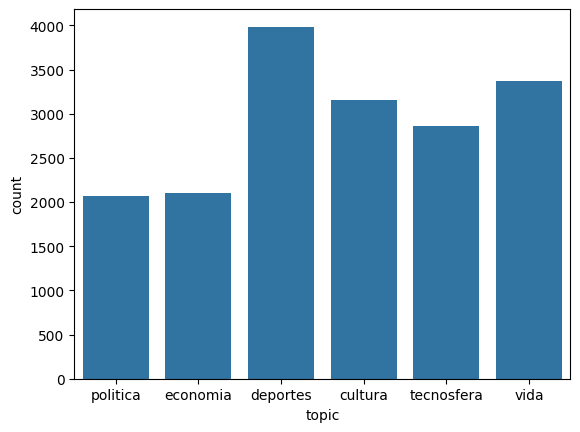

In [11]:
import seaborn as sns
sns.countplot(df_colombia,x='topic')

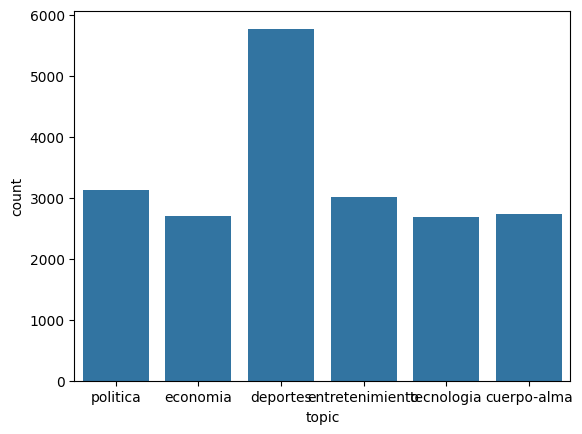

In [12]:
sns.countplot(df_ecuador,x='topic');

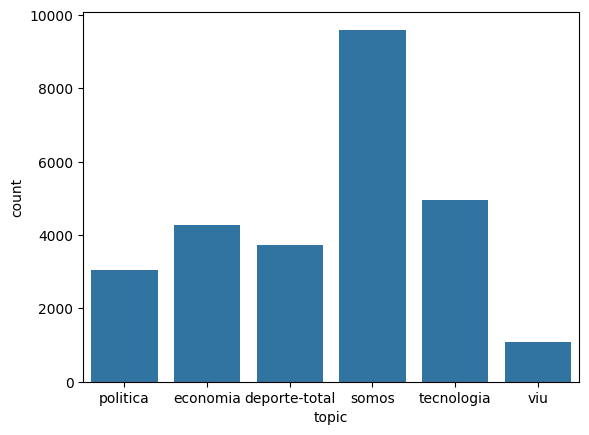

In [13]:
sns.countplot(df_peru,x='topic');

In [14]:
df_colombia['procedencia'] = 'colombia'
df_ecuador['procedencia'] = 'ecuador'
df_peru['procedencia'] = 'peru'

df_news = pd.concat([df_colombia, df_ecuador, df_peru], axis=0, ignore_index=True)

In [15]:
df_news.isna().value_counts()

id     text   topic  procedencia
False  False  False  False          64287
Name: count, dtype: int64

In [16]:
df_news.head()

id   
0  ObjectId("5fc67d400c0ad7d76d154f56")  \
1  ObjectId("5fc67d420c0ad7d76d154f58")   
2  ObjectId("5fc67d450c0ad7d76d154f5a")   
3  ObjectId("5fc67d470c0ad7d76d154f5c")   
4  ObjectId("5fc67d490c0ad7d76d154f5e")   

                                                text     topic procedencia  
0  La Registraduría Nacional fijó en 52.000 pesos...  politica    colombia  
1  Presentar proyectos de ley para ‘tocar’ el sue...  politica    colombia  
2  La emergencia sanitaria, que está activa desde...  politica    colombia  
3  La reforma al código electoral, que trae modif...  politica    colombia  
4  Campesinos, comerciantes, niños, miembros de l...  politica    colombia

In [17]:
news = df_news['text'].tolist()
news

['La Registraduría Nacional fijó en 52.000 pesos el precio de la nueva cédula electrónica, la cual está a disposición de los ciudadanos que quieran obtenerla, desde este martes.Así se lo confirmaron a EL TIEMPO fuentes de la entidad electoral, luego del análisis anunciado por el registrador Nacional, Alexánder Vega, quien había dicho que el valor sería el mismo del duplicado de la cédula (46.000 pesos), más un “ajuste”.(Le puede interesar:\xa0¿Quiénes pueden solicitar la cédula digital desde hoy y cuánto cuesta?)\xa0“Siempre he dicho que se debe mantener el valor más un ajuste del Índice de Precios al Consumidor (IPC). Estamos hablando que son dos cédulas en una: una electrónica, física, y otra digital, en el celular. Estamos buscando un precio accesible a los colombianos, manteniendo los mismos precios de la actualidad”, afirmó Vega la semana pasada.(Lea también:\xa0Así es la nueva cédula digital que se usará en Colombia)Tras esta evaluación que estaba haciendo la Registraduría se det

In [27]:
import spacy
import en_core_web_sm
from tqdm import tqdm
nlp = en_core_web_sm.load()
nlp.add_pipe("textdescriptives/descriptive_stats")

docs_news = nlp.pipe(news)
df_news_f = td.extract_df(docs_news)

In [28]:
df_news_f.to_csv('./news_feaures.csv')

In [32]:
df_news_f

text  token_length_mean   
0      La Registraduría Nacional fijó en 52.000 pesos...           5.028571  \
1      Presentar proyectos de ley para ‘tocar’ el sue...           4.969256   
2      La emergencia sanitaria, que está activa desde...           5.317549   
3      La reforma al código electoral, que trae modif...           5.162304   
4      Campesinos, comerciantes, niños, miembros de l...           4.864947   
...                                                  ...                ...   
64282  Periodista maria.perez@comercio.com.peRamalia ...           4.795918   
64283  Periodista maria.perez@comercio.com.peConforme...           4.754947   
64284  El Comercio buenas.practicas@comercio.com.peZe...           4.785047   
64285  Periodista luciana.villegas@comercio.com.peCon...           4.483175   
64286  Periodista maria.perez@comercio.com.peEs casi ...           4.613267   

       token_length_median  token_length_std  sentence_length_mean   
0                      5.0          3.110745             24.500000  \
1                      4.0          3.107152             36.352941   
2                      5.0          3.425205             25.642857   
3                      4.0          3.383026             30.560000   
4                      4.0          3.118543             24.867925   
...                    ...               ...                   ...   
64282                  4.0          3.086562             18.052632   
64283                  4.0          2.981819             18.250000   
64284                  4.0          3.775296             19.454545   
64285                  4.0          2.935226             16.557143   
64286                  4.0          2.959362             29.592593   

       sentence_length_median  sentence_length_std  syllables_per_token_mean   
0                        18.5            18.656098                  1.497959  \
1                        38.0            20.984423                  1.517799   
2                        23.5            20.527359                  1.640669   
3                        28.0            21.205811                  1.583770   
4                        23.0            15.607252                  1.500759   
...                       ...                  ...                       ...   
64282                    17.0            11.593890                  1.460641   
64283                    17.0            11.008519                  1.441400   
64284                    20.0             7.352966                  1.495327   
64285                    15.0             9.835266                  1.389129   
64286                    27.0            17.569458                  1.375469   

       syllables_per_token_median  syllables_per_token_std  n_tokens   
0                             1.0                 0.801145       245  \
1                             1.0                 0.883418       618   
2                             1.0                 0.918164       359   
3                             1.0                 0.934812       764   
4                             1.0                 0.894893      1318   
...                           ...                      ...       ...   
64282                         1.0                 0.812114       686   
64283                         1.0                 0.756498       657   
64284                         1.0                 0.874069       214   
64285                         1.0                 0.767942      1159   
64286                         1.0                 0.705210       799   

       n_unique_tokens  proportion_unique_tokens  n_characters  n_sentences  
0                  136                  0.555102          1271           10  
1                  301                  0.487055          3140           17  
2                  191                  0.532033          1950           14  
3                  367                  0.480366          4039           25  
4                  427                  0.3239

In [59]:
df_news_features = df_news_f.join(df_news.drop(['text', 'id'], axis=1))
df_news_features = df_news_features.dropna()

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

le = LabelEncoder()
le.fit(df_news_features['procedencia'].unique())
df_news_features['classes_p'] = le.transform(df_news_features['procedencia'])

X = df_news_features.drop(['text', 'topic', 'procedencia', 'classes_p'], axis=1).values
y = df_news_features['classes_p'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
X_train

array([[5.14673913e+00, 4.00000000e+00, 3.38036051e+00, ...,
        3.38315217e-01, 3.95500000e+03, 3.70000000e+01],
       [4.68811881e+00, 4.00000000e+00, 3.04126039e+00, ...,
        4.67821782e-01, 1.93200000e+03, 8.00000000e+00],
       [5.00259403e+00, 4.00000000e+00, 3.16924153e+00, ...,
        4.77302205e-01, 3.95700000e+03, 2.60000000e+01],
       ...,
       [4.92119089e+00, 4.00000000e+00, 3.19682789e+00, ...,
        5.30647986e-01, 2.90800000e+03, 2.70000000e+01],
       [4.70113852e+00, 4.00000000e+00, 3.02626996e+00, ...,
        4.47817837e-01, 5.09300000e+03, 3.80000000e+01],
       [4.81188119e+00, 4.00000000e+00, 3.00976257e+00, ...,
        4.64108911e-01, 4.00300000e+03, 2.80000000e+01]])

In [66]:
modelB = LogisticRegression ()

X_train_s = X_train
X_test_s = X_test
modelB.fit(X_train_s, y_train)
train_preds = modelB.predict(X_train_s)
preds = modelB.predict(X_test_s)
train_f1 = f1_score(y_train, train_preds, average='micro')
test_f1 = f1_score(y_test, preds, average='micro')
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, preds)
train_roc = roc_auc_score(y_train, modelB.predict_proba(X_train_s), multi_class='ovr')
test_roc = roc_auc_score(y_test, modelB.predict_proba(X_test_s), multi_class='ovr')

print(f'Model: Logistic Regression')
print(f'Training F1: {train_f1}')
print(f'Test F1: {test_f1}')
print(f'Training ROC AUC: {train_roc}')
print(f'Test ROC AUC: {test_roc}')
print(f'Training Acc: {train_acc}')
print(f'Test Acc: {test_acc}')
print('-----------------------')   

Model: Logistic Regression
Training F1: 0.7468444444444444
Test F1: 0.7537073524836669
Training ROC AUC: 0.8791280521061787
Test ROC AUC: 0.8822146646033756
Training Acc: 0.7468444444444444
Test Acc: 0.7537073524836669
-----------------------


/home/danielcrovo/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import timeit
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score


pipe = Pipeline([('scaler', StandardScaler())])


In [68]:
def get_models():
    models = dict()
    
    models['Logistic Regression'] = LogisticRegression(random_state=42, max_iter=1000)
    
    models['Decision Tree'] = DecisionTreeClassifier(random_state=42)
    
    models['Random Forest'] = RandomForestClassifier(random_state=42)
    
    models['Extra Trees'] = ExtraTreesClassifier(random_state=42)
    
    models['Gradient Boosting'] = GradientBoostingClassifier(random_state=42)
    
    models['Hist Gradient Boosting'] = HistGradientBoostingClassifier(random_state=42)
    
    models['AdaBoost'] = AdaBoostClassifier(random_state=42) 
                
    
    return models

In [69]:
models = get_models()
results = list()
def evaluate_models(X_train, X_test, y_train, y_test, pipe):
    for name, model in models.items():
        X_train_s = pipe.fit_transform(X_train)
        X_test_s = pipe.fit_transform(X_test)
        model.fit(X_train_s, y_train)
        train_preds = model.predict(X_train_s)
        preds = model.predict(X_test_s)
        train_f1 = f1_score(y_train, train_preds, average='micro')
        test_f1 = f1_score(y_test, preds, average='micro')
        train_acc = accuracy_score(y_train, train_preds)
        test_acc = accuracy_score(y_test, preds)
        train_roc = roc_auc_score(y_train, model.predict_proba(X_train_s), multi_class='ovr')
        test_roc = roc_auc_score(y_test, model.predict_proba(X_test_s), multi_class='ovr')
        scores = {'name': name, 
                  'train_f1': train_f1, 
                  'test_f1': test_f1, 
                  'train_roc': train_roc, 
                  'test_roc': test_roc,
                  'train_acc': train_acc, 
                  'test_acc': test_acc}
        
        
        print(f'Model: {name}')
        print(f'Training F1: {train_f1}')
        print(f'Test F1: {test_f1}')
        print(f'Training ROC AUC: {train_roc}')
        print(f'Test ROC AUC: {test_roc}')
        print(f'Training Acc: {train_acc}')
        print(f'Test Acc: {test_acc}')
        print('-----------------------')        
        results.append(scores)



In [70]:
evaluate_models(X_train, X_test, y_train, y_test, pipe)

Model: Logistic Regression
Training F1: 0.7746444444444445
Test F1: 0.7832624701856269
Training ROC AUC: 0.899647454844871
Test ROC AUC: 0.9035932099918266
Training Acc: 0.7746444444444445
Test Acc: 0.7832624701856269
-----------------------
Model: Decision Tree
Training F1: 1.0
Test F1: 0.9170901171834491
Training ROC AUC: 1.0
Test ROC AUC: 0.938360199079962
Training Acc: 1.0
Test Acc: 0.9170901171834491
-----------------------
Model: Random Forest
Training F1: 1.0
Test F1: 0.9863631649901483
Training ROC AUC: 1.0
Test ROC AUC: 0.9987848090646304
Training Acc: 1.0
Test Acc: 0.9863631649901483
-----------------------
Model: Extra Trees
Training F1: 1.0
Test F1: 0.9861557606553977
Training ROC AUC: 1.0
Test ROC AUC: 0.9993830942437444
Training Acc: 1.0
Test Acc: 0.9861557606553977
-----------------------
Model: Gradient Boosting
Training F1: 0.8459111111111111
Test F1: 0.8246914860520586
Training ROC AUC: 0.952091024607233
Test ROC AUC: 0.9415203242397062
Training Acc: 0.845911111111111